<a href="https://colab.research.google.com/github/Chygos/Zindi/blob/main/Runmila%20Tuberculosis%20clasification/Runmila_TB_Classification5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, files

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path = "drive/My Drive/Zindi/TB XRay Challenge/"

In [5]:
!pip install imutils -q
import os,gc, warnings
warnings.filterwarnings('ignore')

In [7]:
#os.listdir(path)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
import cv2, imutils
from functools import partial

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
from tensorflow.keras import layers, optimizers, Sequential,Model
import tensorflow.keras as tf_keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as inception_preprocess_input

In [11]:
#for reproducibility
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [12]:
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
subfile = pd.read_csv(path+'SampleSubmission.csv')
train_path = path+'train_small/'
test_path = path+'test_small/'

In [13]:
train.shape,test.shape

((718, 3), (82, 2))

In [14]:
train.head(4)

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1


In [15]:
test.head(3)

,filename,ID
0,test/GTWSHFYQ.png,GTWSHFYQ
1,test/QTFSSMGD.png,QTFSSMGD
2,test/TBLBHSYT.png,TBLBHSYT


In [16]:
subfile.head(2)

,ID,LABEL
0,GTWSHFYQ,0
1,QTFSSMGD,0


In [17]:
train_ids = train.ID.values
test_ids = test.ID.values
train_labels = train.LABEL

In [18]:
train_images = pd.DataFrame({'filepath' : train_path+train_ids+'.png', 'ID' : train_ids, 'LABEL' : train_labels})
test_images = pd.DataFrame({'filepath' : test_path+test_ids+'.png', 'ID' : test_ids})

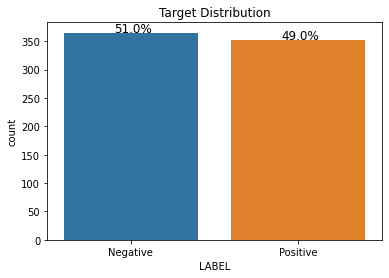

In [19]:
ax = sns.countplot(train_images.LABEL)
plt.xticks(range(2), ['Negative', 'Positive'])
for i in ax.patches:
  plt.text(i.get_x()+0.3, i.get_height()+0.2, str(np.round(i.get_height()/len(train),2)*100)+'%',
           fontsize=12, fontweight=60)
plt.title('Target Distribution');

In [20]:
train_images.head(2)

,filepath,ID,LABEL
0,drive/My Drive/Zindi/TB XRay Challenge/train_s...,VTYNBFTO,1
1,drive/My Drive/Zindi/TB XRay Challenge/train_s...,GVVXXDOZ,0


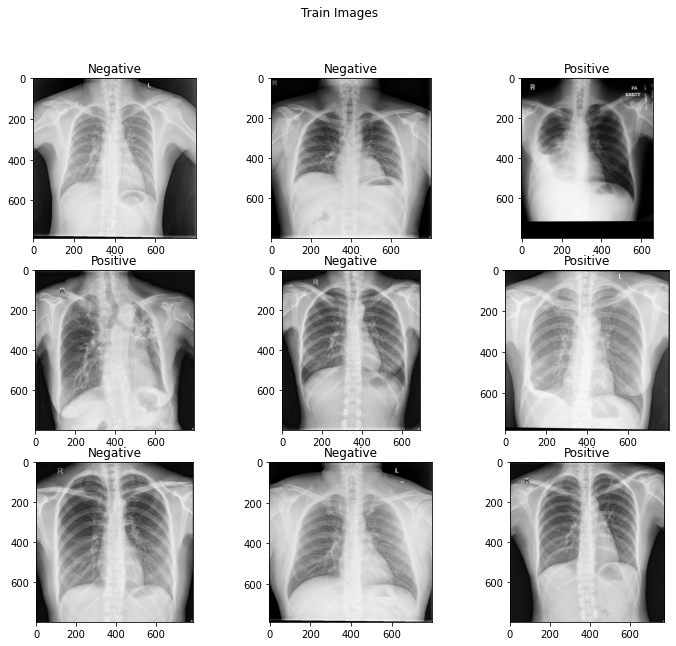

In [21]:
plt.figure(figsize=(12,10))
for i in range(9):
  img_data = train_images.sample(1)
  img = cv2.imread(img_data.iloc[0].filepath)
  plt.subplot(3,3, i+1)
  plt.imshow(img)
  label_map = {0:'Negative', 1:'Positive'}
  plt.title(label_map.get(img_data.LABEL.iloc[0], None))
plt.suptitle('Train Images');

In [22]:
f = cv2.imread(train_images.sample(1).iloc[0].filepath)
f.shape
#The image is of shape 797 x 800 pixels

(800, 775, 3)

Image Processing
In order to crop the part that contains only the chest region from the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. This code was gotten from <a href="https://github.com/Chygos/Brain-Tumor-Detection/blob/master/Brain%20Tumor%20Detection.ipynb"> this link.</a>


In [23]:
def crop_chest_contour(image, plot=False):
  """
  This crops the image to get a clear view of the affected chest region
  parameters
  ----------
  image: Image
  plot: For plotting original and cropped images
  """  
  # Convert the image to grayscale, and blur it slightly
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)

  # Threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # Find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  

  # Find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  
  # crop new image out of the original image using the four extreme points (left, right, top, bottom)
  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

  if plot:
      plt.figure()

      plt.subplot(1, 2, 1)
      plt.imshow(image)
      
      plt.tick_params(axis='both', which='both', 
                      top=False, bottom=False, left=False, right=False,
                      labelbottom=False, labeltop=False, labelleft=False, labelright=False)
      
      plt.title('Original Image')
          
      plt.subplot(1, 2, 2)
      plt.imshow(new_image)

      plt.tick_params(axis='both', which='both', 
                      top=False, bottom=False, left=False, right=False,
                      labelbottom=False, labeltop=False, labelleft=False, labelright=False)

      plt.title('Cropped Image')
      
      plt.show()
  
  return new_image

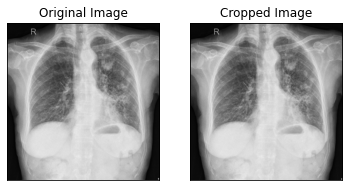

In [24]:
img_crop = crop_chest_contour(f,plot=True)

In [27]:
#splitting data into train and validatio sets
train_data, valid_data= train_test_split(train_images, random_state=SEED, test_size=0.2, stratify=train_images.LABEL)

In [28]:
train_data.shape, valid_data.shape

((574, 3), (144, 3))

In [29]:
print(train_data.LABEL.value_counts())
print(valid_data.LABEL.value_counts())

0    292
1    282
Name: LABEL, dtype: int64
0    73
1    71
Name: LABEL, dtype: int64


In [30]:
train_data.LABEL = train_data.LABEL.map({0:'Negative', 1:'Positive'}) #converting label to string for image data generator requirement
valid_data.LABEL = valid_data.LABEL.map({0:'Negative', 1:'Positive'})

**VGG**

In [31]:
#Data generators and data augmentation of train set
train_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess_input, 
                                   horizontal_flip=True, vertical_flip=True,zoom_range=0.1, 
                                   rotation_range=10, width_shift_range=0.2, height_shift_range=0.1, 
                                   channel_shift_range=1., shear_range=0.1, fill_mode='nearest', 
                                   brightness_range=(0.3, 1.0))

valid_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess_input) #dont perform data augmentation on both validation and test sets

In [32]:
image_size= (224,224)
batch_size = 32
train_steps = len(train_data) // batch_size
valid_steps = len(valid_data) // batch_size

classes = train_data.LABEL.unique().tolist()

In [33]:
train_gen= train_datagen.flow_from_dataframe(train_data, x_col = 'filepath', y_col='LABEL', target_size=image_size, classes=classes,
                                             class_mode='categorical', seed=SEED, batch_size=batch_size, shuffle=True)

val_gen = valid_datagen.flow_from_dataframe(valid_data, x_col='filepath', y_col='LABEL', target_size=image_size, class_mode='categorical',
                                            classes=classes, shuffle=False, batch_size=batch_size, seed=SEED)#dont shuffle val or test data

test_gen = valid_datagen.flow_from_dataframe(test_images, class_mode=None, x_col = 'filepath', target_size=image_size, shuffle=False, 
                                             batch_size=batch_size)

Found 574 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


**Model Building**

**`With Pretrained Models`**

In [34]:
input_shape= (224, 224, 3) #height, width, channels

In [137]:
def BaseModel(base_model=VGG16):
  """Functional API of Keras
  """
  base_model= base_model(include_top=False, weights='imagenet', input_shape=input_shape)
  x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
  # x = BatchNormalization()(x)
  x = Dropout(0.2, name='top_dropout')(x)
  output = Dense(2, name='output_layer')(x)
  output = layers.Activation('softmax')(output)
  model = Model(base_model.input, output)
  base_model.trainable = False #freezing weights of base model to only train on the last layers added
  return model

In [138]:
model = BaseModel()

In [139]:
#checking if base model weights are frozen
model.layers[0].trainable

False

In [140]:
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [144]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-3), metrics=['AUC'])

In [145]:
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
checkpoint_path = os.path.join(path, 'vgg_pretrained_model3.h5')
modelcheck = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', 
                             mode='auto', save_best_only=True, verbose=1)

In [146]:
history = model.fit(train_gen, epochs=30, steps_per_epoch=train_steps, shuffle=True, validation_steps=valid_steps,
                    validation_data=(val_gen), callbacks=[es, modelcheck], verbose=2);

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.21435, saving model to drive/My Drive/Zindi/TB XRay Challenge/vgg_pretrained_model3.h5
17/17 - 15s - loss: 1.2348 - auc: 0.6547 - val_loss: 1.2144 - val_auc: 0.6660
Epoch 2/30

Epoch 00002: val_loss improved from 1.21435 to 0.99039, saving model to drive/My Drive/Zindi/TB XRay Challenge/vgg_pretrained_model3.h5
17/17 - 15s - loss: 1.1511 - auc: 0.6923 - val_loss: 0.9904 - val_auc: 0.7095
Epoch 3/30

Epoch 00003: val_loss improved from 0.99039 to 0.96008, saving model to drive/My Drive/Zindi/TB XRay Challenge/vgg_pretrained_model3.h5
17/17 - 14s - loss: 0.9783 - auc: 0.7126 - val_loss: 0.9601 - val_auc: 0.7260
Epoch 4/30

Epoch 00004: val_loss improved from 0.96008 to 0.94312, saving model to drive/My Drive/Zindi/TB XRay Challenge/vgg_pretrained_model3.h5
17/17 - 14s - loss: 0.8472 - auc: 0.7758 - val_loss: 0.9431 - val_auc: 0.7429
Epoch 5/30

Epoch 00005: val_loss improved from 0.94312 to 0.90631, saving model to drive/My Drive/Z

In [147]:
tr_auc = history.history['auc']
val_auc = history.history['val_auc']
tr_loss = history.history['loss']
val_loss = history.history['val_loss']

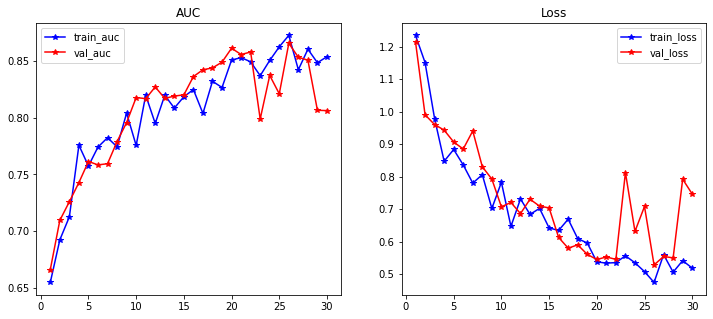

In [148]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(1, len(tr_auc)+1), tr_auc, 'b-*', label='train_auc')
plt.plot(range(1, len(tr_auc)+1), val_auc, 'r-*', label='val_auc')
plt.title('AUC')
plt.legend()

plt.subplot(122)
plt.plot(range(1, len(tr_auc)+1), tr_loss, 'b-*', label='train_loss')
plt.plot(range(1, len(tr_auc)+1), val_loss, 'r-*', label='val_loss')
plt.title('Loss')
plt.legend();

**Fine Tuning Model**

In [ ]:
#vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [323]:
def fineTuneModel(base_model=VGG16):
  """
  Fine tunes the model by unfreezing some of the layers in the pretrained model
  """
  base_model= base_model(include_top=False, weights='imagenet', input_shape=input_shape)
  base_model.trainable = False #freezing weights of base model
  
  #unfreezing layers 4 and 5
  for layer in base_model.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
      layer.trainable = True

  x = GlobalAveragePooling2D(name='avg_pool_ftune')(base_model.output)
  x = BatchNormalization()(x)
  x = Dropout(0.2, name='top_dropout')(x)
  x = Dense(1024, activation='relu')(x)
  # x = BatchNormalization()(x)
  x = Dropout(0.2, name='dropout2')(x)
  output = Dense(2, name='output_layer')(x)
  output = layers.Activation('softmax')(output)
  model = Model(base_model.input, output,name='Finetune')
  return model

In [324]:
model = fineTuneModel()

In [325]:
model.summary()

Model: "Finetune"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [326]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['AUC']) 

In [327]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint_path = os.path.join(path, 'fineTuned_vgg_pretrained_model4.h5')
modelcheck = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

In [328]:
history = model.fit(train_gen, epochs=30, steps_per_epoch=train_steps, shuffle=True, validation_steps=valid_steps,
                    validation_data=(val_gen), callbacks=[es, modelcheck], verbose=2);

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.69240, saving model to drive/My Drive/Zindi/TB XRay Challenge/fineTuned_vgg_pretrained_model4.h5
17/17 - 16s - loss: 0.6796 - auc: 0.6784 - val_loss: 0.6924 - val_auc: 0.7002
Epoch 2/30

Epoch 00002: val_loss improved from 0.69240 to 0.64221, saving model to drive/My Drive/Zindi/TB XRay Challenge/fineTuned_vgg_pretrained_model4.h5
17/17 - 15s - loss: 0.5614 - auc: 0.7887 - val_loss: 0.6422 - val_auc: 0.7533
Epoch 3/30

Epoch 00003: val_loss improved from 0.64221 to 0.54169, saving model to drive/My Drive/Zindi/TB XRay Challenge/fineTuned_vgg_pretrained_model4.h5
17/17 - 15s - loss: 0.5350 - auc: 0.8116 - val_loss: 0.5417 - val_auc: 0.8284
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.54169
17/17 - 14s - loss: 0.4836 - auc: 0.8531 - val_loss: 0.5494 - val_auc: 0.8345
Epoch 5/30

Epoch 00005: val_loss did not improve from 0.54169
17/17 - 13s - loss: 0.4544 - auc: 0.8694 - val_loss: 0.5850 - val_auc: 0.8330
Epoch 6/30

Ep

In [329]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=train_steps, shuffle=True, validation_steps=valid_steps,
                    validation_data=(val_gen), callbacks=[es, modelcheck], verbose=2);

Epoch 1/10

Epoch 00001: val_loss did not improve from 0.35178
17/17 - 13s - loss: 0.2499 - auc: 0.9618 - val_loss: 0.5536 - val_auc: 0.8801
Epoch 2/10

Epoch 00002: val_loss did not improve from 0.35178
17/17 - 13s - loss: 0.2433 - auc: 0.9645 - val_loss: 0.4981 - val_auc: 0.8948
Epoch 3/10

Epoch 00003: val_loss did not improve from 0.35178
17/17 - 13s - loss: 0.2155 - auc: 0.9723 - val_loss: 0.5666 - val_auc: 0.8791
Epoch 4/10

Epoch 00004: val_loss did not improve from 0.35178
17/17 - 13s - loss: 0.2409 - auc: 0.9636 - val_loss: 0.6519 - val_auc: 0.8667
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.35178
17/17 - 13s - loss: 0.2237 - auc: 0.9696 - val_loss: 0.5823 - val_auc: 0.8757
Epoch 6/10

Epoch 00006: val_loss did not improve from 0.35178
17/17 - 13s - loss: 0.2470 - auc: 0.9625 - val_loss: 0.4195 - val_auc: 0.9191
Epoch 7/10

Epoch 00007: val_loss did not improve from 0.35178
17/17 - 13s - loss: 0.2124 - auc: 0.9734 - val_loss: 0.5007 - val_auc: 0.8914
Epoch 8/10

E

In [330]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=train_steps, shuffle=True, validation_steps=valid_steps,
                    validation_data=(val_gen), callbacks=[es, modelcheck], verbose=2);

Epoch 1/10

Epoch 00001: val_loss did not improve from 0.35178
17/17 - 14s - loss: 0.1962 - auc: 0.9773 - val_loss: 0.6911 - val_auc: 0.8398
Epoch 2/10

Epoch 00002: val_loss improved from 0.35178 to 0.33386, saving model to drive/My Drive/Zindi/TB XRay Challenge/fineTuned_vgg_pretrained_model4.h5
17/17 - 16s - loss: 0.1767 - auc: 0.9820 - val_loss: 0.3339 - val_auc: 0.9371
Epoch 3/10

Epoch 00003: val_loss did not improve from 0.33386
17/17 - 14s - loss: 0.1850 - auc: 0.9806 - val_loss: 0.5164 - val_auc: 0.8918
Epoch 4/10

Epoch 00004: val_loss improved from 0.33386 to 0.32678, saving model to drive/My Drive/Zindi/TB XRay Challenge/fineTuned_vgg_pretrained_model4.h5
17/17 - 15s - loss: 0.1920 - auc: 0.9783 - val_loss: 0.3268 - val_auc: 0.9396
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1642 - auc: 0.9830 - val_loss: 0.4083 - val_auc: 0.9197
Epoch 6/10

Epoch 00006: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1679 - auc: 0.9836 -

In [331]:
history = model.fit(train_gen, epochs=7, steps_per_epoch=train_steps, shuffle=True, validation_steps=valid_steps,
                    validation_data=(val_gen), callbacks=[es, modelcheck], verbose=2);

Epoch 1/7

Epoch 00001: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1578 - auc: 0.9855 - val_loss: 0.8474 - val_auc: 0.8230
Epoch 2/7

Epoch 00002: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1754 - auc: 0.9815 - val_loss: 0.5718 - val_auc: 0.8784
Epoch 3/7

Epoch 00003: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1381 - auc: 0.9904 - val_loss: 0.5235 - val_auc: 0.8950
Epoch 4/7

Epoch 00004: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1158 - auc: 0.9937 - val_loss: 0.4815 - val_auc: 0.9067
Epoch 5/7

Epoch 00005: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1577 - auc: 0.9855 - val_loss: 0.6433 - val_auc: 0.8771
Epoch 6/7

Epoch 00006: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1376 - auc: 0.9895 - val_loss: 0.7589 - val_auc: 0.8506
Epoch 7/7

Epoch 00007: val_loss did not improve from 0.32678
17/17 - 13s - loss: 0.1318 - auc: 0.9904 - val_loss: 0.4865 - val_auc: 0.9112


In [332]:
tr_auc = history.history['auc']
val_auc = history.history['val_auc']
tr_loss = history.history['loss']
val_loss = history.history['val_loss']

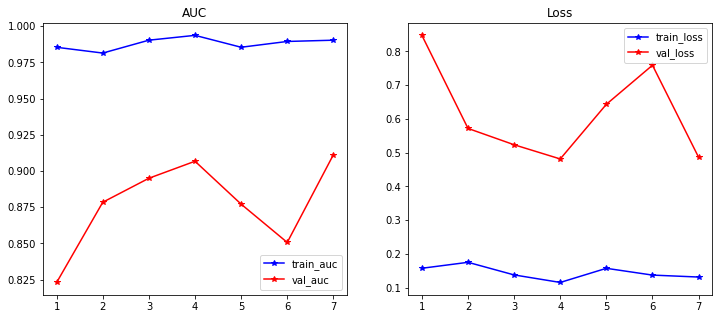

In [333]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(1, len(tr_auc)+1), tr_auc, 'b-*', label='train_auc')
plt.plot(range(1, len(tr_auc)+1), val_auc, 'r-*', label='val_auc')
plt.title('AUC')
plt.legend()

plt.subplot(122)
plt.plot(range(1, len(tr_auc)+1), tr_loss, 'b-*', label='train_loss')
plt.plot(range(1, len(tr_auc)+1), val_loss, 'r-*', label='val_loss')
plt.title('Loss')
plt.legend();

<b>Predictions</b>

In [334]:
y_preds = model.predict(val_gen)[:,1]

In [335]:
auc_score = roc_auc_score(val_gen.classes, y_preds)
fpr, tpr, thresholds = roc_curve(val_gen.classes, y_preds)

In [336]:
auc(fpr, tpr)

0.9235963727570904

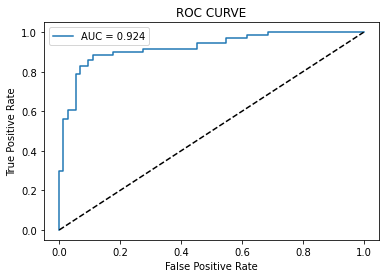

In [337]:
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend();

**Submission**

In [338]:
test_preds = model.predict(test_gen)[:, 1]

In [339]:
submission = pd.DataFrame({'ID': test_ids, 'LABEL':test_preds})

In [340]:
submission.head()

,ID,LABEL
0,GTWSHFYQ,0.077520
1,QTFSSMGD,0.000086
2,TBLBHSYT,0.954813
3,ZKETEOFG,0.101686
4,GKTPBGZP,0.083274


In [341]:
submission.to_csv(os.path.join(path, 'finetuned_vgg_pretrained_model4.csv'), index=False)

In [342]:
files.download(path+'finetuned_vgg_pretrained_model4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**LB Score = ~0.93665**<br>
**Final LB= ~0.9345**

In [343]:
gc.collect()

56158